In [1]:
import numpy as np

from jax import numpy as jp

from jax import jit,grad
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import cvxpy as cp

from RKHS import Gram

%load_ext autoreload
%autoreload 2

In [2]:
def h(r,c,l):
    return c * jp.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(jp.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

In [3]:
def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,jp.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*jp.log(jp.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*jp.log(jp.linalg.det(KA))

In [4]:
def rand_search(x0,R,objective,T,step_size):
    xss = []
    vals = []
    for _ in range(50000):
        
        xs = [x0]
        for i in range(T-1):
            
            cand_x = 0
            while True:
                r = step_size

                theta = np.random.rand()*2*np.pi

                cand_x = xs[-1]+r*np.array([np.cos(theta),np.sin(theta)])

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)

        xs = np.array(xs)
        val = objective(xs)
        
        xss.append(xs)
        vals.append(val)
            
    return xss[np.argmax(vals)],np.max(vals),xss,vals

In [5]:

def project(z,ref,R,step_size):
    # Setup the projection optimization problem

    z_proj = cp.Variable(z.shape)

    # Step size constraints
    constraints = [cp.norm(z_proj[i+1]-z_proj[i])<=step_size for i in range(T-1)] 

    # # Bounded search region constraints
    constraints += [cp.norm(z_proj[i]-ref[j])<=R[i,j] for i in range(T) for j in range(N)]

    prob = cp.Problem(cp.Minimize(cp.norm(z_proj-z)),constraints)

    prob.solve()
    
    return z_proj.value

In [6]:

T = 19

c = 1
l = 1
var_0 = 0.01
objective = jit(lambda z: GPMI(z,c=c,l=l,var_0=var_0))


search_region_center = np.array([0,0])
search_region_radius = 1
step_size = 1

kernel = partial(k,c=c,l=l)

In [7]:

g = jit(grad(objective))

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T
R[0,0] = 0

N = len(ref)


# Random search I

**No** bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    x_t\gets x_{t-1} + D * \text{ random unit vector}
$$


In [8]:
_,_,xss,vals = rand_search(search_region_center,\
                         search_region_radius,objective,T,step_size)

In [9]:
top_n = 5

top_xs = np.array(xss)[np.argsort(vals)[-top_n:]]

# Projected Gradient in $z=x_{1:T}$

In [10]:
n_iter = 100
delta_tolerance = 1e-7 # If ||z_{t+1}-z_t||<delta_tolerance, terminate the algorithm.
eta = 0.01 # The learning rate for gradient update

pg_zs = []

for m,z_0 in enumerate(top_xs):
    
    print('{}th start outof {}.'.format(m,len(top_xs)))
    
    # z_0 = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size # set z_0 to be the straight line

    z = np.array(z_0)

    best_z = z_0
    best_val = objective(z_0)

    for _ in range(n_iter):
        z += eta * g(z) # Gradient step
        z = project(z,ref,R,step_size) # Projection
        if objective(z)> best_val:
            best_z = z
    
    pg_zs.append(best_z)

0th start outof 5.
1th start outof 5.
2th start outof 5.
3th start outof 5.
4th start outof 5.


# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [11]:

d = h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*np.array(h(R,c=c,l=l))
b[0,0] = h(0,c=c,l=l) # Initial location constraint.

In [12]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [B>=b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [13]:
upper_bound

41.9926920148211

# Honeycomb lattice in 2D

A equi-distance honeycomb lattice with $k$ layers has $6k^2+1$ vertices.

If there are $T$ vertices, we need $L = \lceil \sqrt{\frac{T-1}{6}} \rceil$ layers.

Fitting these $L$ layers into a ball with radius $R$, the distance between two neighboring vertices in the lattice is at most $R/L$.

In [14]:
from Lattice import honeycomb

In [15]:
N_layer = int(np.ceil(np.sqrt((T-1)/6)))+1

hive=honeycomb(search_region_radius,N_layer)

# PG using honeycomb as the initial state

In [16]:
n_iter = 100
delta_tolerance = 1e-7 # If ||z_{t+1}-z_t||<delta_tolerance, terminate the algorithm.
eta = 0.01 # The learning rate for gradient update

    
# z_0 = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size # set z_0 to be the straight line

z_0 = hive
z = np.array(z_0)

best_z_hive = z_0
best_val = objective(z_0)

for _ in range(n_iter):
    z += eta * g(z) # Gradient step
    z = project(z,ref,R,step_size) # Projection
    if objective(z)> best_val:
        best_z_hive = z
    


# Equi-angular placement

In [17]:
thetas = np.linspace(0,2*np.pi,T)[:-1]
equi_angle = search_region_center.reshape(-1,1)+search_region_radius*np.array([np.cos(thetas),np.sin(thetas)])
equi_angle = np.vstack([equi_angle.T,search_region_center])

# PG using equi angular placement as the initial state

In [21]:
n_iter = 100
delta_tolerance = 1e-7 # If ||z_{t+1}-z_t||<delta_tolerance, terminate the algorithm.
eta = 0.01 # The learning rate for gradient update

    
# z_0 = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size # set z_0 to be the straight line

z_0 = equi_angle
z = np.array(z_0)

best_z_equi = z_0
best_val = objective(z_0)

for _ in range(n_iter):
    z += eta * g(z) # Gradient step
    z = project(z,ref,R,step_size) # Projection
    if objective(z)> best_val:
        best_z_equi = z
    


# Compare the solutions and the upper bound

In [22]:
sols = {
    'Random Brute Force': top_xs[-1],
        'Equi-Angle': equi_angle,
    'Honeycomb':hive,
#         'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size,
        'PG-BruteInit': best_z,
    'PG-EquiInit':best_z_equi,
    'PG-HiveInit':best_z_hive,
       }
alphas = {
    'Random Brute Force': 0.5,
       'Equi-Angle': 1,
        'Honeycomb':1,
#         'Straight Line': 0.5,
        'PG-BruteInit': 1,
    'PG-EquiInit':1,
    'PG-HiveInit':1,
       } 
colors = {
    'Random Brute Force': 'grey',
     'Equi-Angle': 'blue',
    'Honeycomb':'orange',
#         'Straight Line': 'orange',
        'PG-BruteInit': 'green',
        'PG-EquiInit':'purple',
    'PG-HiveInit':'red',
       } 


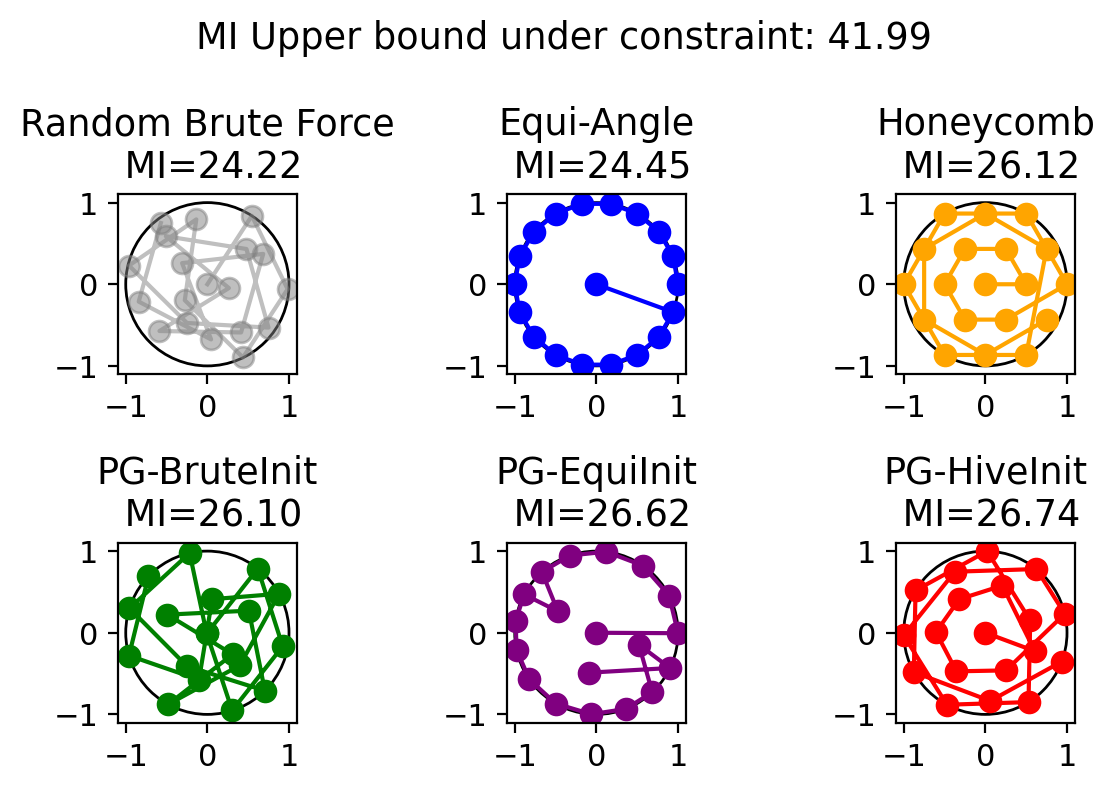

In [23]:

plt.rc('font',size=11)
fig,axes = plt.subplots(2,3,dpi=200,figsize=(6,4))

axes = axes.flatten()

for l,(key,val) in enumerate(sols.items()):
    ax = axes[l]
    ax.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.2f}".format(key,objective(val)),\
             alpha = alphas[key],
            color = colors[key])
    
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("{}\n MI={:.2f}".format(key,objective(val)))
    
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.suptitle('MI Upper bound under constraint: {:.2f}'.format(upper_bound))

plt.tight_layout()
plt.show()